In [20]:
# Data import
import pandas as pd
import numpy as np

used_car = pd.read_csv("used_cars.csv")
used_car.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


### First, additional information can be extracted from the dataset. The following steps involve feature engineering, which will be applied before conducting EDA.

In [21]:
# Transform milage and price into numerical features
used_car['milage'] = used_car['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)
used_car['price'] = used_car['price'].str.replace('$', '').str.replace(',', '').astype('int64')

In [22]:
# Unify nan in fuel_type 
print(used_car["fuel_type"].unique())
used_car['fuel_type'] = used_car['fuel_type'].replace(['–', 'not supported'], np.nan)
print(used_car["fuel_type"].unique())

['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid']


In [23]:
print(len(used_car["engine"].unique()))
print(len(used_car["transmission"].unique()))

1146
62


Both the "engine" and "transmission" columns are categorical variables with too many distinct categories, which limits their predictive usefulness in their current form. However, since both columns contain detailed descriptions as strings, valuable information can still be extracted. From the "engine" column, I can derive attributes such as horsepower, engine displacement, the number of cylinders, and whether the engine is turbocharged. Similarly, from the "transmission" column, I can extract whether it is automatic or manual and the number of gears.

In [24]:
# Extract horsepower from engine
def extract_horsepower(engine):
    match = pd.Series(engine).str.extract(r'(\d+\.?\d*)HP')
    return match[0] if not match.empty else np.nan

used_car['horsepower'] = used_car['engine'].apply(extract_horsepower).astype(float)

In [25]:
# Extract engine displacement from engine
def extract_displacement(engine):
    match = pd.Series(engine).str.extract(r'(\d+\.?\d*)\s*(L|Liter)')
    return match[0] if not match.empty else np.nan

used_car['displacement'] = used_car['engine'].apply(extract_displacement).astype(float)

In [26]:
# Extract cylinders from engine
def extract_cylinders(engine):
    match = pd.Series(engine).str.extract(r'(?:V|I)(\d+)|(\d+)\s*Cylinder')
    return match[0].combine_first(match[1]) if not match.empty else np.nan

used_car['cylinders'] = used_car['engine'].apply(extract_cylinders).astype(float)

In [27]:
# Determine whether an engine has turbo
def extract_turbo(engine):
    if "turbo" in engine.lower():
        return True
    else:
        return False
    
used_car['turbo'] = used_car['engine'].apply(extract_turbo)

In [28]:
unique_engines = used_car[['engine', 'horsepower', 'displacement', 'cylinders','turbo']].drop_duplicates()
display(unique_engines)

,engine,horsepower,displacement,cylinders,turbo
0,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,300.0,3.7,6.0,False
1,3.8L V6 24V GDI DOHC,NaN,3.8,6.0,False
2,3.5 Liter DOHC,NaN,3.5,NaN,False
3,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,354.0,3.5,6.0,False
4,2.0L I4 16V GDI DOHC Turbo,NaN,2.0,4.0,True
...,...,...,...,...,...
3942,400.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,400.0,5.0,8.0,False
3943,211.0HP 2.0L 4 Cylinder Engine Diesel Fuel,211.0,2.0,4.0,False
3974,136.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,136.0,1.8,4.0,False
3977,270.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,270.0,2.0,4.0,False


In [29]:
# Classify Transmission into Automatic, Manual and Other
def classify_transmission(transmission):
    if "manual" in transmission.lower() or "m/t" in transmission.lower():
        return "Manual"
    elif "automatic" in transmission.lower() or "a/t" in transmission.lower():
        return "Automatic"
    else:
        return "Unknown"

used_car['transmission_type'] = used_car['transmission'].apply(classify_transmission)

In [30]:
# Create a new column num_gears by extracting the number of gears from transmission
def extract_gears(transmission):
    match = pd.Series(transmission).str.extract(r'(\d+)')
    return match[0] if not match.empty else np.nan

used_car['num_gears'] = used_car['transmission'].apply(extract_gears).astype(float)

In [31]:
# Check the transmission_type, and num_gears of each unique transformation
# pd.set_option('display.max_rows', None)
unique_transmissions = used_car[['transmission', 'transmission_type', 'num_gears']].drop_duplicates()
display(unique_transmissions)

,transmission,transmission_type,num_gears
0,6-Speed A/T,Automatic,6.0
1,8-Speed Automatic,Automatic,8.0
2,Automatic,Automatic,NaN
3,7-Speed A/T,Automatic,7.0
5,F,Unknown,NaN
...,...,...,...
2393,9-Speed Automatic with Auto-Shift,Automatic,9.0
2620,SCHEDULED FOR OR IN PRODUCTION,Unknown,NaN
2772,2-Speed A/T,Automatic,2.0
3206,6 Speed Mt,Unknown,6.0


In [32]:
# Drop engine and transmission columns
used_car.drop(['engine', 'transmission'], axis=1)

,brand,model,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,price,horsepower,displacement,cylinders,turbo,transmission_type,num_gears
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,Black,Black,At least 1 accident or damage reported,Yes,10300,300.0,3.7,6.0,False,Automatic,6.0
1,Hyundai,Palisade SEL,2021,34742,Gasoline,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005,NaN,3.8,6.0,False,Automatic,8.0
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,Blue,Black,None reported,NaN,54598,NaN,3.5,NaN,False,Automatic,NaN
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,Black,Black,None reported,Yes,15500,354.0,3.5,6.0,False,Automatic,7.0
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,Glacier White Metallic,Black,None reported,NaN,34999,NaN,2.0,4.0,True,Automatic,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714,Gasoline,C / C,Hotspur,None reported,Yes,349950,NaN,6.0,NaN,True,Automatic,8.0
4005,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,Black,Black,None reported,Yes,53900,349.0,3.0,6.0,False,Unknown,NaN
4006,Porsche,Taycan,2022,2116,NaN,Black,Black,None reported,NaN,90998,NaN,NaN,NaN,False,Automatic,NaN
4007,Ford,F-150 Raptor,2020,33000,Gasoline,Blue,Black,None reported,Yes,62999,450.0,3.5,6.0,False,Automatic,NaN


### Next, we start the EDA procedures for the transformed dataset.

In [35]:
# dataset dimensions
used_car.shape

(4009, 18)

In [37]:
# Column data types
for col in used_car.columns:
    print(f"Column: {col}, Data type: {used_car[col].dtype}")

Column: brand, Data type: object
Column: model, Data type: object
Column: model_year, Data type: int64
Column: milage, Data type: int64
Column: fuel_type, Data type: object
Column: engine, Data type: object
Column: transmission, Data type: object
Column: ext_col, Data type: object
Column: int_col, Data type: object
Column: accident, Data type: object
Column: clean_title, Data type: object
Column: price, Data type: int64
Column: horsepower, Data type: float64
Column: displacement, Data type: float64
Column: cylinders, Data type: float64
Column: turbo, Data type: bool
Column: transmission_type, Data type: object
Column: num_gears, Data type: float64


In [38]:
# Describe the target variable "sales price"
sales_price = used_car['price']
sales_price.describe()

count    4.009000e+03
mean     4.455319e+04
std      7.871064e+04
min      2.000000e+03
25%      1.720000e+04
50%      3.100000e+04
75%      4.999000e+04
max      2.954083e+06
Name: price, dtype: float64

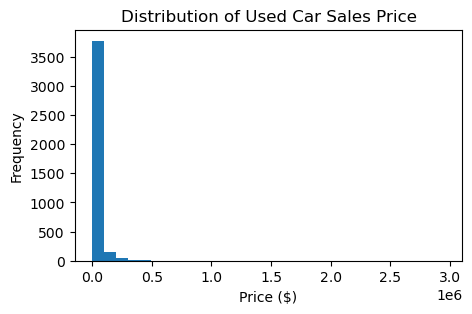

In [39]:
import matplotlib.pyplot as plt

# Histogram of sales_price
plt.figure(figsize=(5,3))
plt.hist(sales_price, bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

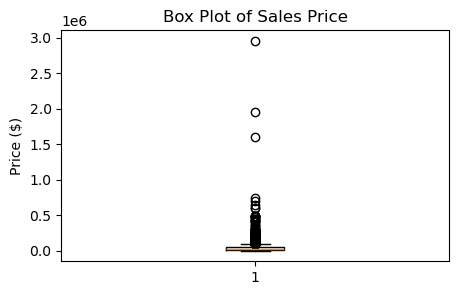

In [40]:
# Boxplot of sales_price
plt.figure(figsize=(5, 3))
plt.boxplot(sales_price)
plt.title('Box Plot of Sales Price')
plt.ylabel('Price ($)')
plt.show()

In [41]:
# reduce outliers
# Identify outliers based on the IQR method
Q1 = sales_price.quantile(0.25)
Q3 = sales_price.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers = used_car[sales_price > upper_bound]

# Display the outliers
print(outliers)


              brand                      model  model_year  milage fuel_type  \
11            Aston    Martin DBS Superleggera        2019   22770  Gasoline   
16    Mercedes-Benz                Metris Base        2021    1685  Gasoline   
44            Lucid          Air Grand Touring        2022    3552       NaN   
61             Audi                 R8 5.2 V10        2018    8940  Gasoline   
71          Bentley         Continental GT W12        2017   14684  Gasoline   
...             ...                        ...         ...     ...       ...   
3964        Porsche                911 Carrera        2022    2950  Gasoline   
3993        Porsche              911 Carrera S        2021    7008  Gasoline   
3994            BMW  M8 Gran Coupe Competition        2022   21057  Gasoline   
4002  Mercedes-Benz          AMG GLS 63 4MATIC        2023    2000    Hybrid   
4004        Bentley       Continental GT Speed        2023     714  Gasoline   

                                       

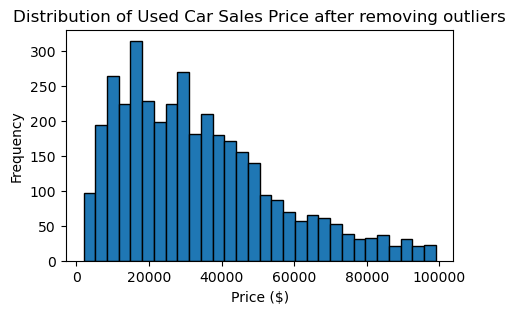

In [50]:
# Remove Outliers
# df_cleaned = used_car[(used_car['price'] >= lower_bound) & (used_car['price'] <= upper_bound)]
sales_price_cleaned = used_car['price'][(used_car['price'] >= lower_bound) & (used_car['price'] <= upper_bound)]
plt.figure(figsize=(5,3))
plt.hist(sales_price_cleaned, bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price after removing outliers")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()


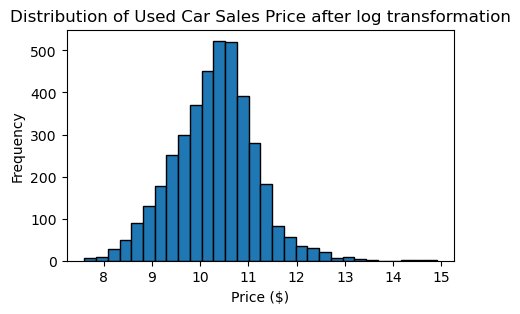

In [51]:
# Log Transformation
sales_price_log = np.log(sales_price)
plt.figure(figsize=(5,3))
plt.hist(sales_price_log, bins=30, edgecolor='black')
plt.title("Distribution of Used Car Sales Price after log transformation")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()


In [45]:
df_sorted = used_car.sort_values(by='price', ascending=True)
df_sorted.head(30)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,displacement,cylinders,turbo,transmission_type,num_gears
425,Lincoln,Aviator Luxury,2005,140000,Gasoline,302.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Beige,None reported,Yes,2000,302.0,4.6,8.0,False,Automatic,NaN
89,Subaru,Forester 2.5 X,2004,210703,Gasoline,165.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,M/T,Green,Beige,NaN,NaN,2300,165.0,2.5,4.0,False,Manual,NaN
3640,Nissan,Maxima GLE,2000,194277,Gasoline,222.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Beige,At least 1 accident or damage reported,Yes,2300,222.0,3.0,6.0,False,Automatic,NaN
3907,Toyota,Camry Solara SLE V6,2000,245000,Gasoline,200.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Beige,At least 1 accident or damage reported,Yes,2500,200.0,3.0,6.0,False,Automatic,NaN
1292,BMW,323 Ci,2000,177700,Gasoline,170.0HP 2.5L Straight 6 Cylinder Engine Gasoli...,5-Speed A/T,Silver,Black,None reported,Yes,2500,170.0,2.5,6.0,False,Automatic,5.0
626,Pontiac,Firebird Base,1999,158000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,4-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,2500,200.0,3.8,6.0,False,Automatic,4.0
3922,Mazda,Protege DX,1993,94200,NaN,–,A/T,Gray,–,At least 1 accident or damage reported,Yes,2500,NaN,NaN,NaN,False,Automatic,NaN
903,Buick,Rainier CXL,2005,147589,Gasoline,275.0HP 4.2L Straight 6 Cylinder Engine Gasoli...,A/T,White,Beige,At least 1 accident or damage reported,Yes,2800,275.0,4.2,6.0,False,Automatic,NaN
3595,Nissan,Altima 2.5 S,2003,189000,Gasoline,175.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,2899,175.0,2.5,4.0,False,Automatic,NaN
2012,Hyundai,Accent GL,2003,83000,Gasoline,104.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,M/T,Blue,Gray,None reported,Yes,2900,104.0,1.6,4.0,False,Manual,NaN
